In [1]:
import glob, pdb

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

import matplotlib.font_manager as fm
my_font = fm.FontProperties(fname='arial.ttc')

def format_rp_rd(rp,rd):
    if rp==int(rp):
        rp = int(rp)
    else:
        rp = round(rp,2)
    rd = rp/2;
    if rd==int(rd):
        rd = int(rd)
    else:
        rd = round(rd,3)
    return rp,rd

def forward_solve(t, IC, Pp, coefficients, param_degree=1, C_degree = 4):
    t_solve_span = (t[0], t[-1])

    return solve_ivp(
                      BDM_RHS, t_solve_span, [IC], t_eval=t,
                        args = (Pp,coefficients,param_degree, C_degree)
                      ).y.T

def BDM_RHS(t, C, Pp, coefs, param_degree=1, C_degree = 4):
    
    assert type(param_degree) in [int,np.ndarray], "param_degree must be int or np.ndarray"
    assert type(C_degree) in [int,np.ndarray], "C_degree must be int or np.ndarray"
    assert type(C_degree) == type(param_degree), "types of param_degree and C_degree must match"
    
    if type(param_degree) == int:
    
        p_deg_mesh, C_deg_mesh = np.meshgrid(np.arange(1,param_degree+1),
                                             np.arange(1,C_degree+1),
                                             indexing = "ij")
        
        features = [(Pp**pdeg)*(C**cdeg) for (pdeg,cdeg) in zip(p_deg_mesh.reshape(-1),
                                                                C_deg_mesh.reshape(-1))] #+ [Pp**2*(C**p) for p in np.arange(1,deg+1)]
    
    elif type(param_degree) == np.ndarray:
        
        features = [(Pp**pdeg)*(C**cdeg) for (pdeg,cdeg) in zip(param_degree,C_degree)] 
        
    X = np.array(features).T
    
    return np.matmul(X,coefs)

def MSE(a,b):
    """
    Calculate the mean squared error between two arrays.

    Args:
        a (numpy.ndarray): The first array.
        b (numpy.ndarray): The second array.

    Returns:
        float: The mean squared error between `a` and `b`.
    """
    #assert a.shape == b.shape
    if a.shape != b.shape:
        return np.nan
    else:
        return ((a - b)**2).mean()   


def cost_function(q,data,t,IC,coefficients,param_degree,C_degree):
    
    Rp = q
    
    true_soln = forward_solve(t, IC, Rp, 
                          coefficients, 
                          param_degree=param_degree, 
                          C_degree = C_degree)
    
    return MSE(true_soln,data)

def ES_sindy_coefficient_values(IC,drp):
    
    if IC == 0.05:
        
        if drp == 0.01:
            # coefficients = np.array([0.36,-2.34, 5.6, -5.0])
            # C_degrees = np.array([1,2,3,4])
            # p_degrees = np.array([1,1,1,1])
            pass
            
        # elif drp == 0.1:
        #     coefficients = np.array([0.34, -1.98, 3.46, -4.06])
        #     C_degrees = np.array([1,2,3,5])
        #     p_degrees = np.array([1,1,1,1])

        elif drp == 0.5:
            coefficients = np.array([0.4, -2.53, 5.81, -4.92])
            C_degrees = np.array([1,2,3,4])
            p_degrees = np.array([1,1,1,1])
            
        elif drp == 1:
            # coefficients = np.array([0.4, -2.27, 3.82, -3.77])
            # C_degrees = np.array([1,2,3,5])
            # p_degrees = np.array([1,1,1,1])
            pass
            
    elif IC == 0.25:
        
        if drp == 0.01:
            # coefficients = np.array([0.34,-0.85])
            # C_degrees = np.array([1,2])
            # p_degrees = np.array([1,1])
            pass
            
        elif drp == 0.1:
            # coefficients = np.array([0.34,-0.85])
            # C_degrees = np.array([1,2])
            # p_degrees = np.array([1,1])
            pass

        elif drp == 0.5:
            coefficients = np.array([0.85, -2.95, 5.24])
            C_degrees = np.array([1,2,4])
            p_degrees = np.array([1,1,1])
            
        elif drp == 1:
            # coefficients = np.array([0.85, -2.92, 5.08])
            # C_degrees = np.array([1,2,4])
            # p_degrees = np.array([1,1,1])
            pass

    return coefficients, C_degrees, p_degrees
    
    
def get_ABM_data(Rp,IC):
    
    Rd = Rp/2

    t = np.linspace(0,20/(Rp-Rd),100)

    Rp,Rd = format_rp_rd(Rp,Rd)
    try:
        filename = f"../../data/data_10datasets_inference/logistic_ABM_sim_rp_{Rp}_rd_{Rd}_rm_1_m_{IC}_real10.npy"
        mat = np.load(filename,allow_pickle=True).item()
    except:
        filename = f"../../data/data_10datasets_inference/logistic_ABM_sim_rp_{int(Rp)}_rd_{Rd}_rm_1_m_{IC}_real10.npy"
        mat = np.load(filename,allow_pickle=True).item()
    C_all = mat["ABM_sim_all"]
    
    return t,C_all

color_mfld      = [216/255,27/255,96/255]
color_es        = [139/255,175/255,81/255]
color_oat       = [30/255,136/255,229/255]
color_oatinterp = [255/255,193/255,7/255]
color_data      = [0,0,0]

## Load in configuration information for three models

In [10]:
IC = 0.05

MF_coefficients = [1/2,-1]
MF_param_degree = 1
MF_C_degree = 2

drp = 0.5
ES_coefficients, ES_C_degrees, ES_param_degrees = ES_sindy_coefficient_values(IC,drp)

if IC == 0.05:
    OAT_coefficients  = np.array([0.00588225,-0.03807943,0.41670982,-0.00164962,
                        -0.06947733,0.31995656,-3.14482333,0.55198162,
                        0.23154828,-0.87875228,7.38023702,-1.95609854,
                        -0.63964883,1.90150333,-13.48880906,4.26817187])
    OAT_param_degrees = np.array([3,2,1,0,3,2,1,0,3,2,1,0,3,2,1,0])
    OAT_C_degrees     = np.array([1,1,1,1,2,2,2,2,3,3,3,3,5,5,5,5])
    
elif IC == 0.25:
    OAT_coefficients  = np.array([-0.10701148,0.93031359,-1.02205957,0.56967568,
                    0.46346364,-4.09428978,5.16984418,-2.42796312,
                    -1.23564389,11.22205699,-16.93077156,6.74796028])
    OAT_param_degrees = np.array([3,2,1,0,3,2,1,0,3,2,1,0])
    OAT_C_degrees     = np.array([1,1,1,1,2,2,2,2,4,4,4,4])

In [11]:
Rp_vals = np.arange(0.01,5.01,0.1)
optimization_initialization_values = [0.0,2.5,5.0]

MF_Rp_errors = []
ES_Rp_errors = []
OAT_Rp_errors = []

for Rp in Rp_vals:

    if int(Rp)+.01==Rp:
        print(Rp)
    
    t,C_all = get_ABM_data(Rp,IC)

    for i in range(10):

        data = C_all[:,i][:,None]

        ########################################
        # Estimate Rp using mean-field model
        ########################################
        
        MF_args = (data,t,IC,MF_coefficients,MF_param_degree,MF_C_degree)
        
        min_fun = np.inf
        for val in optimization_initialization_values:
            MF_ret = minimize(cost_function, val, args=MF_args, tol=1e-6, method = "nelder-mead")
            
            if MF_ret.fun < min_fun:
                min_fun = MF_ret.fun 
                MF_Rp_est = MF_ret.x[0]
        MF_Rp_error = np.abs(Rp - MF_Rp_est)

        ########################################
        # Estimate Rp using ES ME-EQL
        ########################################        
        
        ES_args = (data,t,IC,ES_coefficients,ES_param_degrees,ES_C_degrees)
        
        min_fun = np.inf
        for val in optimization_initialization_values:
            ES_ret = minimize(cost_function, val, args=ES_args, tol=1e-6, method = "nelder-mead")
            
            if ES_ret.fun < min_fun:
                min_fun = ES_ret.fun 
                ES_Rp_est = ES_ret.x[0]
        ES_Rp_error = np.abs(Rp - ES_Rp_est)

        ########################################
        # Estimate Rp using ES OAT-EQL
        ########################################                
        
        OAT_args = (data,t,IC,OAT_coefficients,OAT_param_degrees,OAT_C_degrees)

        min_fun = np.inf
        for val in optimization_initialization_values:
            OAT_ret = minimize(cost_function, val, args=OAT_args, tol=1e-6, method = "nelder-mead")
            
            if OAT_ret.fun < min_fun:
                min_fun = OAT_ret.fun 
                OAT_Rp_est = OAT_ret.x[0]
        OAT_Rp_error = np.abs(Rp - OAT_Rp_est)
        
        if i == 0:
            MF_Rp_errors_tmp = [MF_Rp_error]
            ES_Rp_errors_tmp = [ES_Rp_error]
            OAT_Rp_errors_tmp = [OAT_Rp_error]
        else:
            MF_Rp_errors_tmp.append(MF_Rp_error)
            ES_Rp_errors_tmp.append(ES_Rp_error)
            OAT_Rp_errors_tmp.append(OAT_Rp_error)

    MF_Rp_errors.append(MF_Rp_errors_tmp)
    ES_Rp_errors.append(ES_Rp_errors_tmp)
    OAT_Rp_errors.append(OAT_Rp_errors_tmp)

MF_Rp_errors = np.array(MF_Rp_errors)
ES_Rp_errors = np.array(ES_Rp_errors)
OAT_Rp_errors = np.array(OAT_Rp_errors)

mean_MF_Rp_errors = np.mean(MF_Rp_errors,axis=1)
std_MF_Rp_errors = np.std(MF_Rp_errors,axis=1)

mean_ES_Rp_errors = np.mean(ES_Rp_errors,axis=1)
std_ES_Rp_errors = np.std(ES_Rp_errors,axis=1)

mean_OAT_Rp_errors = np.mean(OAT_Rp_errors,axis=1)
std_OAT_Rp_errors = np.std(OAT_Rp_errors,axis=1)

0.01


/tmp/ipykernel_217571/712623937.py:48: RuntimeWarning: overflow encountered in power
  features = [(Pp**pdeg)*(C**cdeg) for (pdeg,cdeg) in zip(param_degree,C_degree)]
/tmp/ipykernel_217571/712623937.py:48: RuntimeWarning: invalid value encountered in multiply
  features = [(Pp**pdeg)*(C**cdeg) for (pdeg,cdeg) in zip(param_degree,C_degree)]
/tmp/ipykernel_217571/712623937.py:52: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(X,coefs)
/tmp/ipykernel_217571/712623937.py:48: RuntimeWarning: overflow encountered in square
  features = [(Pp**pdeg)*(C**cdeg) for (pdeg,cdeg) in zip(param_degree,C_degree)]


1.01
2.01
3.01
4.01


In [12]:
save_data = {"Rp_vals":Rp_vals,
             "mean_MF_Rp_errors":mean_MF_Rp_errors,
             "std_MF_Rp_errors":std_MF_Rp_errors,
             "mean_ES_Rp_errors":mean_ES_Rp_errors,
             "std_ES_Rp_errors":std_ES_Rp_errors,
             "mean_OAT_Rp_errors":mean_OAT_Rp_errors,
             "std_OAT_Rp_errors":std_OAT_Rp_errors,
             "IC":IC,
             "color_es":color_es,
             "color_mfld":color_mfld,
             "color_oat":color_oat,
             "drp":drp}

np.save(f"Rp_parameter_estimation_IC_{IC}.npy",save_data)

In [2]:
#IC = 0.25

mat = np.load(f"Rp_parameter_estimation_IC_{IC}.npy",allow_pickle=True).item()

Rp_vals = mat["Rp_vals"]
mean_MF_Rp_errors = mat["mean_MF_Rp_errors"]
std_MF_Rp_errors = mat["std_MF_Rp_errors"]
mean_ES_Rp_errors = mat["mean_ES_Rp_errors"]
std_ES_Rp_errors = mat["std_ES_Rp_errors"]
mean_OAT_Rp_errors = mat["mean_OAT_Rp_errors"]
std_OAT_Rp_errors = mat["std_OAT_Rp_errors"]
drp = mat["drp"]

(0.0, 2.0)

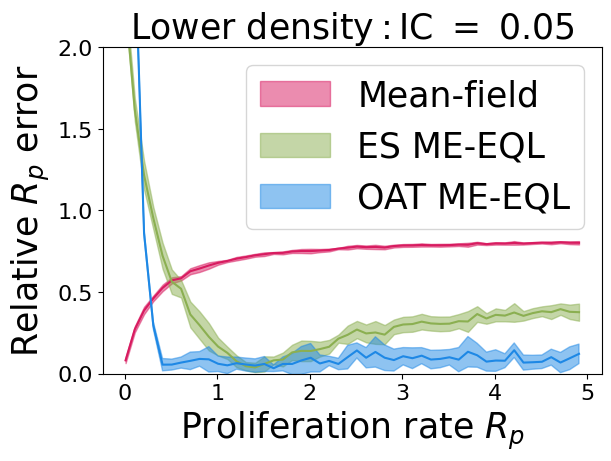

In [13]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig,ax = plt.subplots(1,1,figsize=(6,4.5),layout="constrained")

ax.plot(Rp_vals,mean_MF_Rp_errors/Rp_vals,color=color_mfld)
ax.fill_between(Rp_vals,(mean_MF_Rp_errors-std_MF_Rp_errors)/Rp_vals,
                         (mean_MF_Rp_errors+std_MF_Rp_errors)/Rp_vals,color=color_mfld,alpha=0.5,label="Mean-field")

ax.plot(Rp_vals,mean_ES_Rp_errors/Rp_vals,color=color_es)
ax.fill_between(Rp_vals,(mean_ES_Rp_errors-std_ES_Rp_errors)/Rp_vals,
                         (mean_ES_Rp_errors+std_ES_Rp_errors)/Rp_vals,color=color_es,alpha=0.5,label="ES ME-EQL")

ax.plot(Rp_vals,(mean_OAT_Rp_errors)/Rp_vals,color=color_oat)
ax.fill_between(Rp_vals,(mean_OAT_Rp_errors-std_OAT_Rp_errors)/Rp_vals,
                         (mean_OAT_Rp_errors+std_OAT_Rp_errors)/Rp_vals,color=color_oat,alpha=0.5,label="OAT ME-EQL")

fontsize=25
if IC == 0.05:
    ax.legend(fontsize=fontsize)
    ax.set_title("$\mathrm{Lower\ density: IC\ =\ " + str(IC) + "}$",fontproperties=my_font,fontsize=fontsize)
elif IC == 0.25:
    ax.set_title("$\mathrm{Higher\ density: IC\ =\ " + str(IC) + "}$",fontproperties=my_font,fontsize=fontsize)

ax.set_xlabel("$\mathrm{Proliferation\ rate}\ R_p$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylabel("$\mathrm{Relative}\ R_p\ \mathrm{error}$",fontproperties=my_font,fontsize=fontsize)
ax.set_ylim(0,2.0)

#plt.savefig(f"Figures_paper/ABM_parameter_inference_IC_{IC}.png")

In [14]:
for i in [0,25,-1]:
    
    print(f"Rp = {Rp_vals[i]}")
    
    print("Mean-field:")
    print((mean_MF_Rp_errors[i])/Rp_vals[i])
    print("OAT:")
    print((mean_OAT_Rp_errors[i])/Rp_vals[i] )
    print("ES:")
    print((mean_ES_Rp_errors[i])/Rp_vals[i])
    print("")

Rp = 0.01
Mean-field:
0.08133789062499974
OAT:
53.46406364440919
ES:
2.272558593750001

Rp = 2.51
Mean-field:
0.7785260982437436
OAT:
0.14204544492926688
ES:
0.2701523571850289

Rp = 4.91
Mean-field:
0.8019432179748163
OAT:
0.1212497002626878
ES:
0.37655391980577113

